In [521]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Preprocessing 
import re
import nltk

In [522]:
df = pd.read_csv('QueryResults2.csv')
display(df.head())
print("Shape of Df:",  df.shape)

,Title,Body,Tags,Id,Score,ViewCount,AnswerCount
0,"Android Jetpack Navigation, BottomNavigationVi...","<p>Android Jetpack Navigation, BottomNavigatio...",<android><android-architecture-components><bot...,50577356,81,67388,14
1,JetPack Compose Button with drawable,<p>How can we achieve this in jetpack compose<...,<android><android-jetpack-compose><android-com...,72336943,10,17903,6
2,How to handle back button when at the starting...,<p>I've started working with the new navigatio...,<android-architecture-components><android-arch...,50937116,17,23616,8
3,TopAppBar flashing when navigating with Compos...,<p>I have 2 screens which both have their own ...,<android><android-jetpack><android-jetpack-com...,68633717,19,4757,9
4,How to create recycler view in Compose Jetpack?,<p>Is there any special way to create recycler...,<android><android-recyclerview><android-jetpac...,58691725,17,12553,7


Shape of Df: (50000, 7)


## Preprocessing Steps:
We will use Pipelines fort the preprocessing steps.  
The first steps of preprocessing will involve cleaning the 'Body' column by removing HTML tags and special characters. After that, we will tokenize the cells.

Here are the steps in detail:
1. Clean the 'Body' column by removing HTML tags and special characters.
2. Tokenize the cells.

Please note that these steps are crucial for preparing the data for further analysis or modeling.

### Body

In [523]:
body = []
body= df.iloc[:].Body
print(body)

0        <p>Android Jetpack Navigation, BottomNavigatio...
1        <p>How can we achieve this in jetpack compose<...
2        <p>I've started working with the new navigatio...
3        <p>I have 2 screens which both have their own ...
4        <p>Is there any special way to create recycler...
                               ...                        
49995    <p>I am trying to POST to <a href="http://loca...
49996    <p>I want my form submit button to be disabled...
49997    <p>Consider a Console application that starts ...
49998    <p>I have a code for adding the texts to exist...
49999    <p>Our maven build throws at the end of the bu...
Name: Body, Length: 50000, dtype: object


In [524]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


class TagsCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [self.clean_tags(text) for text in X]

    def clean_tags(self, text):
        tags_to_transform = BeautifulSoup(text, "html.parser")
        return [tag.name for tag in tags_to_transform.find_all()]
    
    '''
    def transform(self, X, y=None):
        return [BeautifulSoup(text, "html.parser").get_text() for text in X]'''
    
class HtmlCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [self.clean_text(text) for text in X]

    def clean_text(self, text):
    # Delete HTML tags
        clean_text = re.sub(r'<.*?>', '', text)
    # Delete special characters and punctuation
        clean_text = re.sub(r'[^a-zA-Z\s]', '', clean_text)
        return clean_text
    
    
    '''def transform(self, X, y=None):
        return [BeautifulSoup(text, "html.parser").get_text() for text in X]'''


class TextTokenizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [nltk.word_tokenize(text) for text in X]

class TextLower(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [[word.lower() for word in text] for text in X]
    
class TextStopWordRemover(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        stop_words = set(nltk.corpus.stopwords.words('english'))
        return [[word for word in text if word not in stop_words] for text in X]
    
class TextLemmatizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [[self.lemmatize(word) for word in text] for text in X]

    def lemmatize(self, word):
        pos_tag = self.get_wordnet_pos(word)
        if pos_tag:
            return self.lemmatizer.lemmatize(word, pos=pos_tag)
        else:
            return word

    def get_wordnet_pos(self, word):
        """Map POS tag to first character used by WordNetLemmatizer"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)
    
pipeline = Pipeline([
    ('html_cleaner', HtmlCleaner()),
    ('tokenizer', TextTokenizer()),
    ('stop_words', TextStopWordRemover()),
    ('text_lower', TextLower()),
    ('tags_cleaner', TagsCleaner()),
    ('lemmatizer',TextLemmatizer())
])

[nltk_data] Downloading package stopwords to /Users/bahia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/bahia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/bahia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/bahia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [525]:
#preprocessed_body = pipeline.transform(doc[:100])
preprocessed_body = pipeline.named_steps['html_cleaner'].transform(body[:100])
preprocessed_body = pipeline.named_steps['tokenizer'].transform(preprocessed_body)
preprocessed_body = pipeline.named_steps['text_lower'].transform(preprocessed_body)
preprocessed_body = pipeline.named_steps['lemmatizer'].transform(preprocessed_body)
print(preprocessed_body[0])




['android', 'jetpack', 'navigation', 'bottomnavigationview', 'with', 'auto', 'fragment', 'back', 'stack', 'on', 'back', 'button', 'click', 'what', 'i', 'want', 'after', 'choose', 'multiple', 'tab', 'one', 'after', 'another', 'by', 'user', 'and', 'user', 'click', 'on', 'back', 'button', 'app', 'must', 'redirect', 'to', 'the', 'last', 'page', 'heshe', 'open', 'i', 'achieve', 'the', 'same', 'use', 'android', 'viewpager', 'by', 'save', 'the', 'currently', 'select', 'item', 'in', 'an', 'arraylist', 'be', 'there', 'any', 'auto', 'back', 'stack', 'after', 'android', 'jetpack', 'navigation', 'release', 'i', 'want', 'to', 'achieve', 'it', 'use', 'navigation', 'graph', 'activitymainxml', 'ltxml', 'version', 'encodingutfgt', 'ltandroidsupportconstraintconstraintlayout', 'xmlnsandroidhttpschemasandroidcomapkresandroid', 'xmlnsapphttpschemasandroidcomapkresauto', 'xmlnstoolshttpschemasandroidcomtools', 'androidididcontainer', 'androidlayoutwidthmatchparent', 'androidlayoutheightmatchparent', 'tools

In [526]:
# frequence des tokens
from collections import defaultdict
def calculate_token_frequency(body):
    token_frequency = defaultdict(int)
    for text in body:
        for token in text:
            token_frequency[token] += 1
    sorted_token_frequency = dict(sorted(token_frequency.items(), key=lambda x: x[1], reverse=True))
    return sorted_token_frequency

token_frequency = calculate_token_frequency(preprocessed_body)


Les mots que l'on retrouve le plus sont des stop word il va donc faloir les supprimer

In [527]:
preprocessed_body = pipeline.named_steps['stop_words'].transform(preprocessed_body)
print(preprocessed_body[:10])

[['android', 'jetpack', 'navigation', 'bottomnavigationview', 'auto', 'fragment', 'back', 'stack', 'back', 'button', 'click', 'want', 'choose', 'multiple', 'tab', 'one', 'another', 'user', 'user', 'click', 'back', 'button', 'app', 'must', 'redirect', 'last', 'page', 'heshe', 'open', 'achieve', 'use', 'android', 'viewpager', 'save', 'currently', 'select', 'item', 'arraylist', 'auto', 'back', 'stack', 'android', 'jetpack', 'navigation', 'release', 'want', 'achieve', 'use', 'navigation', 'graph', 'activitymainxml', 'ltxml', 'version', 'encodingutfgt', 'ltandroidsupportconstraintconstraintlayout', 'xmlnsandroidhttpschemasandroidcomapkresandroid', 'xmlnsapphttpschemasandroidcomapkresauto', 'xmlnstoolshttpschemasandroidcomtools', 'androidididcontainer', 'androidlayoutwidthmatchparent', 'androidlayoutheightmatchparent', 'toolscontextmainmainactivitygt', 'ltfragment', 'androidididmynavhostfragment', 'androidnameandroidxnavigationfragmentnavhostfragment', 'androidlayoutwidthmatchparent', 'andro

In [528]:

token_body_frequency = calculate_token_frequency(preprocessed_body)
print(token_body_frequency)
import matplotlib.pyplot as plt

# Get the top 50 words and their frequencies
top_50_words = list(token_body_frequency.keys())[:50]
top_50_frequencies = list(token_body_frequency.values())[:50]

{'fragment': 105, 'use': 98, 'androidlayoutwidthmatchparent': 94, 'gt': 91, 'public': 63, 'android': 51, 'get': 49, 'try': 48, 'work': 46, 'scroll': 46, 'im': 45, 'androidlayoutheightwrapcontent': 44, 'new': 44, 'error': 44, 'androidlayoutheightmatchparent': 42, 'view': 41, 'void': 40, 'like': 39, 'navigation': 38, 'code': 34, 'ltitem': 33, 'activity': 32, 'implementation': 32, 'want': 31, 'one': 31, 'data': 31, 'navcontroller': 30, 'class': 30, 'null': 30, 'method': 30, 'tz': 30, 'button': 29, 'item': 29, 'return': 29, 'back': 27, 'issue': 27, 'problem': 27, 'user': 26, 'modifier': 26, 'google': 26, 'private': 26, 'function': 26, 'version': 25, 'see': 25, 'need': 25, 'way': 25, 'also': 24, 'override': 24, 'file': 24, 'start': 23, 'layout': 23, 'show': 23, 'menu': 23, 'interface': 23, 'value': 23, 'xmlnsandroidhttpschemasandroidcomapkresandroid': 22, 'however': 22, 'change': 22, 'run': 22, 'go': 22, 'follow': 21, 'icon': 21, 'app': 20, 'action': 20, 'set': 20, 'ive': 19, 'make': 19, 'r

### Title preprocessing

In [529]:
title = df.iloc[:].Title

preprocessed_title = pipeline.named_steps['html_cleaner'].transform(title[:100])
preprocessed_title = pipeline.named_steps['tokenizer'].transform(preprocessed_title)
preprocessed_title = pipeline.named_steps['stop_words'].transform(preprocessed_title)
preprocessed_title = pipeline.named_steps['text_lower'].transform(preprocessed_title)
preprocessed_title = pipeline.named_steps['lemmatizer'].transform(preprocessed_title)
print(preprocessed_title)

[['android', 'jetpack', 'navigation', 'bottomnavigationview', 'youtube', 'instagram', 'like', 'proper', 'back', 'navigation', 'fragment', 'back', 'stack'], ['jetpack', 'compose', 'button', 'drawable'], ['how', 'handle', 'back', 'button', 'start', 'destination', 'navigation', 'component'], ['topappbar', 'flash', 'navigate', 'compose', 'navigation'], ['how', 'create', 'recycler', 'view', 'compose', 'jetpack'], ['jetpackcompose', 'navigation', 'nest', 'graph', 'cause', 'viewmodelstore', 'set', 'setgraph', 'call', 'exception'], ['how', 'get', 'navhostfragment'], ['how', 'align', 'title', 'layout', 'center', 'topappbar'], ['jetpack', 'compose', 'lazycolumn', 'programmatically', 'scroll', 'item'], ['collapse', 'appbarlayout', 'scroll', 'tablayout', 'nestedscrollview'], ['google', 'map', 'android', 'api', 'authorization', 'failure', 'ensure', 'google', 'map', 'android', 'api', 'v', 'enable', 'ensure', 'follow', 'android', 'key', 'exists'], ['visual', 'studio', 'suddenly', 'debug', 'test'], ['

In [530]:
# Title tokens frequency
token_title_frequency = calculate_token_frequency(preprocessed_title)
print(token_title_frequency)


# Get the top 50 words and their frequencies
top_50_words = list(token_title_frequency.keys())[:50]
top_50_frequencies = list(token_title_frequency.values())[:50]

{'android': 26, 'how': 16, 'navigation': 14, 'compose': 12, 'jetpack': 11, 'fragment': 10, 'use': 9, 'button': 8, 'component': 6, 'scroll': 6, 'google': 6, 'design': 6, 'item': 5, 'color': 5, 'back': 4, 'v': 4, 'why': 4, 'function': 4, 'error': 4, 'recyclerview': 4, 'architecture': 4, 'change': 4, 'show': 4, 'inside': 4, 'view': 3, 'cause': 3, 'set': 3, 'call': 3, 'get': 3, 'navhostfragment': 3, 'layout': 3, 'collapse': 3, 'api': 3, 'method': 3, 'release': 3, 'unable': 3, 'load': 3, 'cloud': 3, 'single': 3, 'principle': 3, 'material': 3, 'collapsingtoolbarlayout': 3, 'new': 3, 'language': 3, 'what': 3, 'data': 3, 'float': 3, 'action': 3, 'support': 3, 'library': 3, 'null': 3, 'drawable': 2, 'handle': 2, 'destination': 2, 'topappbar': 2, 'create': 2, 'recycler': 2, 'nest': 2, 'title': 2, 'lazycolumn': 2, 'nestedscrollview': 2, 'map': 2, 'ensure': 2, 'key': 2, 'visual': 2, 'studio': 2, 'toolbar': 2, 'class': 2, 'firebase': 2, 'http': 2, 'responsibility': 2, 'interface': 2, 'segregation':

### Tags

In [531]:

tags = df.iloc[:].Tags
#print(tags)
preprocessed_tags = pipeline.named_steps['tags_cleaner'].transform(tags[:100])
print(preprocessed_tags)

[['android', 'android-architecture-components', 'bottomnavigationview', 'android-navigation', 'android-architecture-navigation'], ['android', 'android-jetpack-compose', 'android-compose-textfield', 'android-compose-button', 'android-jetpack-compose-button'], ['android-architecture-components', 'android-architecture-navigation', 'android-navigation', 'android-jetpack-navigation'], ['android', 'android-jetpack', 'android-jetpack-compose', 'android-jetpack-navigation', 'android-jetpack-compose-scaffold'], ['android', 'android-recyclerview', 'android-jetpack-compose', 'android-jetpack-compose-list', 'android-compose-lazyfor'], ['kotlin', 'android-jetpack-compose', 'android-jetpack', 'android-architecture-navigation', 'jetpack-compose-navigation'], ['android', 'android-fragments', 'android-architecture-components', 'fragmentmanager', 'android-architecture-navigation'], ['android', 'android-jetpack-compose', 'android-jetpack', 'android-jetpack-compose-material3', 'android-compose-appbar'], [

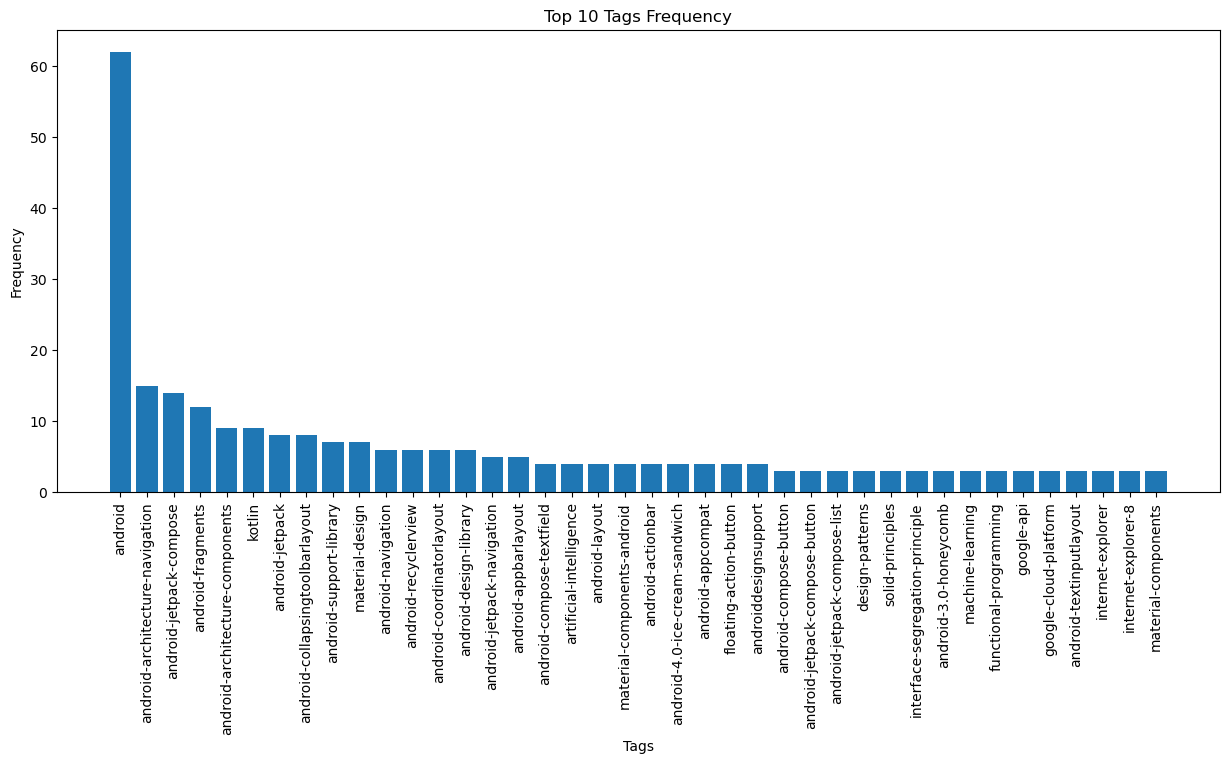

In [532]:
# Tags frequency
tags_frequency = calculate_token_frequency(preprocessed_tags)

# Get the top 10 tags and their frequencies
top_10_tags = list(tags_frequency.keys())[:40]
top_10_frequencies = list(tags_frequency.values())[:40]

# Plot the tags frequency
plt.figure(figsize=(15, 6))
plt.bar(top_10_tags, top_10_frequencies)
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Top 10 Tags Frequency')
plt.xticks(rotation=90)
plt.show()


android                            62
android-architecture-components     9
bottomnavigationview                2
android-navigation                  6
android-architecture-navigation    15
                                   ..
visual-studio-2013                  1
visual-studio-2019                  1
uninstallation                      1
google-oauth                        1
google-api-java-client              1
Length: 238, dtype: int64


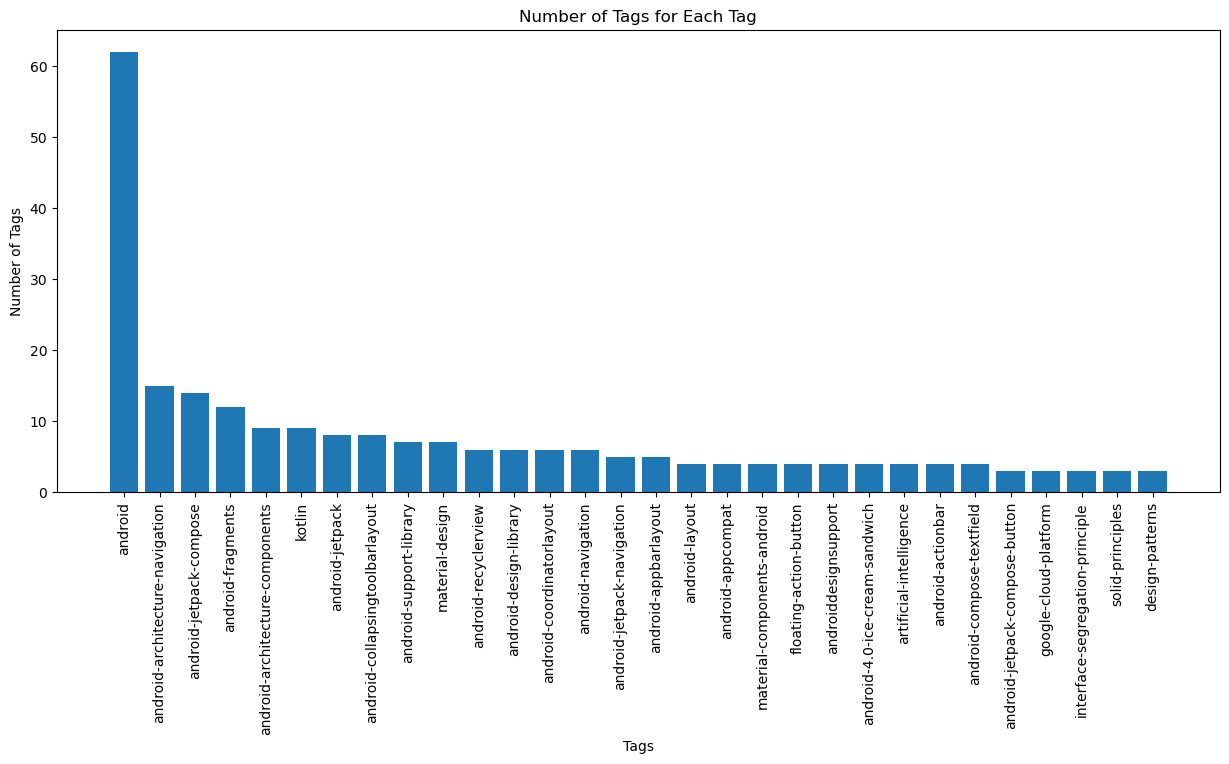

In [533]:
freq_tags = defaultdict(int)
nb_tags = defaultdict(int)
for i in range(len(preprocessed_tags)):
    for tag in preprocessed_tags[i]:
        freq_tags[tag] += 1
        nb_tags[tag] += 1
data_graph = pd.Series(nb_tags)
data_graph
print(data_graph)
data_graph = data_graph.sort_values(ascending=False)

# Plot the number of tags for each tag
plt.figure(figsize=(15, 6))
plt.bar(data_graph.index[:30], data_graph.values[:30])
plt.xlabel('Tags')
plt.ylabel('Number of Tags')
plt.title('Number of Tags for Each Tag')
plt.xticks(rotation=90)
plt.show()



In [534]:
# For each sublist, join its elements into a single string
preprocessed_body = [' '.join(sublist) for sublist in preprocessed_body]
preprocessed_title = [' '.join(sublist) for sublist in preprocessed_title]
preprocessed_tags = [' '.join(sublist) for sublist in preprocessed_tags]

# Convert the lists into DataFrames
df_body = pd.DataFrame(preprocessed_body, columns=['Body'])
df_title = pd.DataFrame(preprocessed_title, columns=['Title'])
df_tags = pd.DataFrame(preprocessed_tags, columns=['Tags'])

# Join the DataFrames
df = pd.concat([df_title, df_body, df_tags], axis=1)
display(df.head())

,Title,Body,Tags
0,android jetpack navigation bottomnavigationvie...,android jetpack navigation bottomnavigationvie...,android android-architecture-components bottom...
1,jetpack compose button drawable,achieve jetpack compose im something like butt...,android android-jetpack-compose android-compos...
2,how handle back button start destination navig...,ive start work new navigation component im rea...,android-architecture-components android-archit...
3,topappbar flash navigate compose navigation,screen scaffold topappbar navigate use jetpack...,android android-jetpack android-jetpack-compos...
4,how create recycler view compose jetpack,special way create recyclerview compose jetpac...,android android-recyclerview android-jetpack-c...


La longueur moyenne des questions en nombre de mots est de 92.22.
le nombre total de mots : 9222
The number of unique words in df['Body'] is: 2890


/Users/bahia/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Body_word_count', ylabel='Count'>

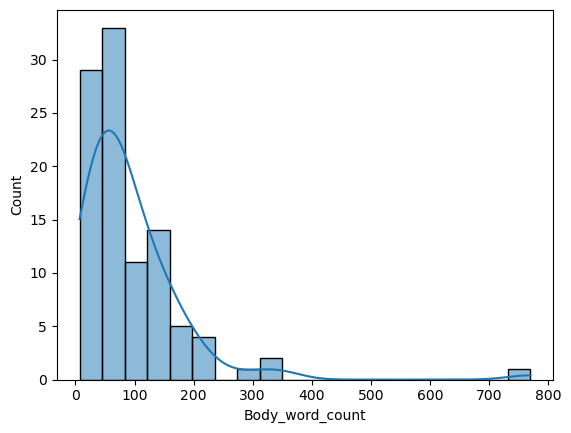

In [535]:

def count_words(text):
    return len(text.split())

# Appliquer la fonction à la colonne 'Body' du jeu de données
df['Body_word_count'] = df['Body'].apply(count_words)

# Calculer la longueur moyenne des questions en nombre de mots
mean_word_count = df['Body_word_count'].mean()

# Nombre de mots et nombre de mots unique dans body
unique_words_count = len(set(' '.join(df['Body']).split()))
total_word_count = df['Body_word_count'].sum() 

print(f"La longueur moyenne des questions en nombre de mots est de {mean_word_count:.2f}.")
print("le nombre total de mots :",total_word_count)
print("The number of unique words in df['Body'] is:", unique_words_count)

sns.histplot(df['Body_word_count'], kde=True, bins=20)



In [536]:
from sklearn.feature_extraction.text import CountVectorizer
# Créer une instance de CountVectorizer
vectorizer = CountVectorizer()

# Convertir les données en vecteurs de fréquence de mots
X_body = vectorizer.fit_transform(df['Body'])

# Afficher le vecteur de fréquence de mots pour la première ligne de 'Body'
print(X_body)
print(X_body.shape)




  (0, 87)	3
  (0, 1529)	2
  (0, 1887)	4
  (0, 658)	2
  (0, 583)	2
  (0, 1213)	2
  (0, 592)	5
  (0, 2506)	2
  (0, 690)	2
  (0, 742)	2
  (0, 2811)	2
  (0, 728)	1
  (0, 1825)	1
  (0, 2573)	1
  (0, 1978)	2
  (0, 440)	1
  (0, 2758)	2
  (0, 454)	1
  (0, 1827)	1
  (0, 2245)	1
  (0, 1553)	2
  (0, 2040)	1
  (0, 1343)	1
  (0, 2006)	2
  (0, 15)	2
  :	:
  (98, 1083)	2
  (98, 1161)	1
  (98, 368)	1
  (98, 285)	1
  (98, 193)	1
  (98, 256)	1
  (98, 220)	1
  (98, 676)	1
  (98, 1313)	1
  (98, 2289)	1
  (99, 2756)	1
  (99, 1272)	1
  (99, 1299)	1
  (99, 1540)	1
  (99, 509)	1
  (99, 2298)	1
  (99, 1096)	2
  (99, 450)	1
  (99, 981)	1
  (99, 2562)	1
  (99, 2618)	1
  (99, 525)	1
  (99, 1949)	1
  (99, 1488)	1
  (99, 1068)	1
(100, 2880)


In [537]:


# Obtenir la liste des mots du vocabulaire

vocab = vectorizer.get_feature_names_out()

# Extraire la première ligne de X_body
first_row = X_body[1]

# Convertir la première ligne en un dictionnaire avec les mots comme clés et les valeurs comme valeurs
first_row_dict = {vocab[i]: first_row[0, i] for i in range(len(vocab))}

# Créer un DataFrame à partir du dictionnaire
df_first_row = pd.DataFrame([first_row_dict])

# Filtrer le DataFrame pour inclure uniquement les colonnes avec des valeurs non nulles
df_first_row_filtered = df_first_row.loc[:, df_first_row.sum() > 0]

# Afficher le DataFrame filtré
display(df_first_row_filtered)


,achieve,alignmentcenter,border,borderstrokedp,box,boxmodifier,button,buttondefaultsbuttoncolorsbackgroundcolor,buttondefaultselevation,buttontext,...,shadowdp,shape,sizedp,something,spacermodifier,start,text,textalign,textaligncenter,tint
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,3,1,1,1
